# Visualisations

Much of the visual work done for this project is available elsewhere. This document contains two of the less obvious plots and how to construct them.

# 1. Radar of sound features

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Read in any relevant spotify data
spot_data = pd.read_csv('../SQL_SpotifyMetrics_Export.csv')

In [8]:
# Set up the relevant features we're interested in
sound_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                  'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
                  'time_signature', 'valence']


In [11]:
# Check Kendrick and Bob Dyaln
spot_data[(spot_data['song_name']=='Like a Rolling Stone') | (spot_data['song_name']=='i')][sound_features]

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
6020          0.729         0.483     369600.0   0.721               0.0  0.0   
17554         0.708         0.541     336013.0   0.809               0.0  8.0   

       liveness  loudness  mode  speechiness    tempo  time_signature  valence  
6020      0.189    -6.836   1.0        0.032   95.261             4.0    0.562  
17554     0.720    -4.286   1.0        0.324  120.094             4.0    0.753

In [9]:
# Prep scaler for viz
def scale(var):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(var),
                        columns = var.columns,
                        index = var.index)

In [10]:
scaled_spot_data = scale(spot_data[sound_features]).applymap(lambda x: 1-x)

In [12]:
scaled_spot_data['artistName'] = spot_data['artistName']
scaled_spot_data['songName'] = spot_data['song_name']

In [13]:
# Function to plot songs
def plot_song(artists, songs):
    
    # Zip into tuples
    song_tuples = list(zip(artists, songs))
    
    # Create blank dataframe
    to_plot = pd.DataFrame(columns = [*sound_features, 'artistName', 'songName'])
    
    # Bring all plotting data into frame
    for artist, song in song_tuples:

        to_plot = pd.concat([(scaled_spot_data[
        (scaled_spot_data['artistName']==artist) 
        & (scaled_spot_data['songName']==song)][sound_features]), to_plot], axis = 0, sort = False)

    
    # Remove non numerical data from dataframe...
    to_plot.drop(['artistName', 'songName'], axis = 1, inplace = True)
    # And replace index with text date
    to_plot.index = [(str(artist) + ' / ' + str(song)) for song, artist in song_tuples]
    
    # Prep list of features
    cols = list(to_plot.columns)
    
    # Melt to get into correct dataformat
    to_plot = pd.melt(to_plot.T)
    # Check dimensions
    to_plot['Sound Features'] = cols*len(song_tuples)
    # Rename for plotting purposes
    to_plot.columns = ['Song', 'Values', 'Sound Features']
    
    # Create it
    fig = px.line_polar(to_plot, r="Values", theta="Sound Features", color='Song', line_close=True,
                    color_discrete_sequence=px.colors.sequential.RdBu,
                    template="plotly_white",)
    # Show it off
    fig.show()
    

In [14]:
# Pick artists
artists = ['Bob Dylan', 'Kendrick Lamar', 'Jeff Buckley', 'Miles Davis']
# Pick songs
songs = ['Like a Rolling Stone', 'i', 'Hallelujah', 'Bitches Brew']

# Plot them!
plot_song(artists, songs)

# 2. Word Clouds

In [15]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from random import randint
import joblib

In [29]:
# Control colours 
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

# Create word cloud
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                          background_color="white", color_func=random_color_func,
                          collocations=False).generate(text)
    return wordcloud

# Create subplots of wordclouds
def create_cluster_plot(dim_x, dim_y, df):

    '''
    dim_x - how many wordclouds in x-dir
    dim_y - how many wordclouds in y-dir
    df - dataframe
    '''
    
    fig = plt.figure(figsize = (30,30))
    for i in range(len(df.clusters.value_counts())):
        text = ', '.join(list(df[df['clusters']==i]['artistName']))
        ax = fig.add_subplot(dim_y,dim_x,i+1)
        wordcloud = plot_word_cloud(text)
        ax.imshow(wordcloud)
        ax.axis('off')
        plt.title(('Cluster '+str(i)))

    plt.tight_layout()
    plt.show()

In [30]:
def prep_data(data):
    data.drop_duplicates(inplace = True)
    data[desc_list] = data[desc_list].applymap(lambda x: str(x).strip().replace('nan', 'None'))
    df.dropna(inplace = True)
    return data

In [31]:
# Descriptors arent necessary but useful for post analysis
df = pd.read_csv('../Cluster_Data.csv')
desc_list = ['desc1', 'desc2', 'desc3', 'desc4', 'desc5']
df = prep_data(df)

In [21]:
optimal_cluster_model = joblib.load('../FinalClusterModel.sav')

In [22]:
df['clusters'] = optimal_cluster_model.labels_

In [25]:
df[sound_features] = scale(df[sound_features])

In [26]:
cluster_rym_data = df[['album', 'song_name', 
                             'artist', 'genre', 'desc1',
                             'desc2', 'desc3', 'desc4',
                             'desc5', 'clusters']].rename(columns = {
    
    'album':'albumName',
    'song_name':'songName',
    'artist':'artistName',
    'genre':'genreName'
    
    
})

In [27]:
# Select most popular genre name
cluster_rym_data['genreName'] = cluster_rym_data['genreName'].apply(lambda x: x.split(',')[0])

In [32]:
cluster_rym_data.head()

albumName                     songName artistName         genreName  \
0  OK Computer                       Airbag  Radiohead  Alternative Rock   
1  OK Computer             Paranoid Android  Radiohead  Alternative Rock   
2  OK Computer  Subterranean Homesick Alien  Radiohead  Alternative Rock   
3  OK Computer      Exit Music (For a Film)  Radiohead  Alternative Rock   
4  OK Computer                     Let Down  Radiohead  Alternative Rock   

         desc1    desc2       desc3       desc4        desc5  clusters  
0  melancholic  anxious  futuristic  alienation  existential        11  
1  melancholic  anxious  futuristic  alienation  existential        20  
2  melancholic  anxious  futuristic  alienation  existential        27  
3  melancholic  anxious  futuristic  alienation  existential         2  
4  melancholic  anxious  futuristic  alienation  existential        30

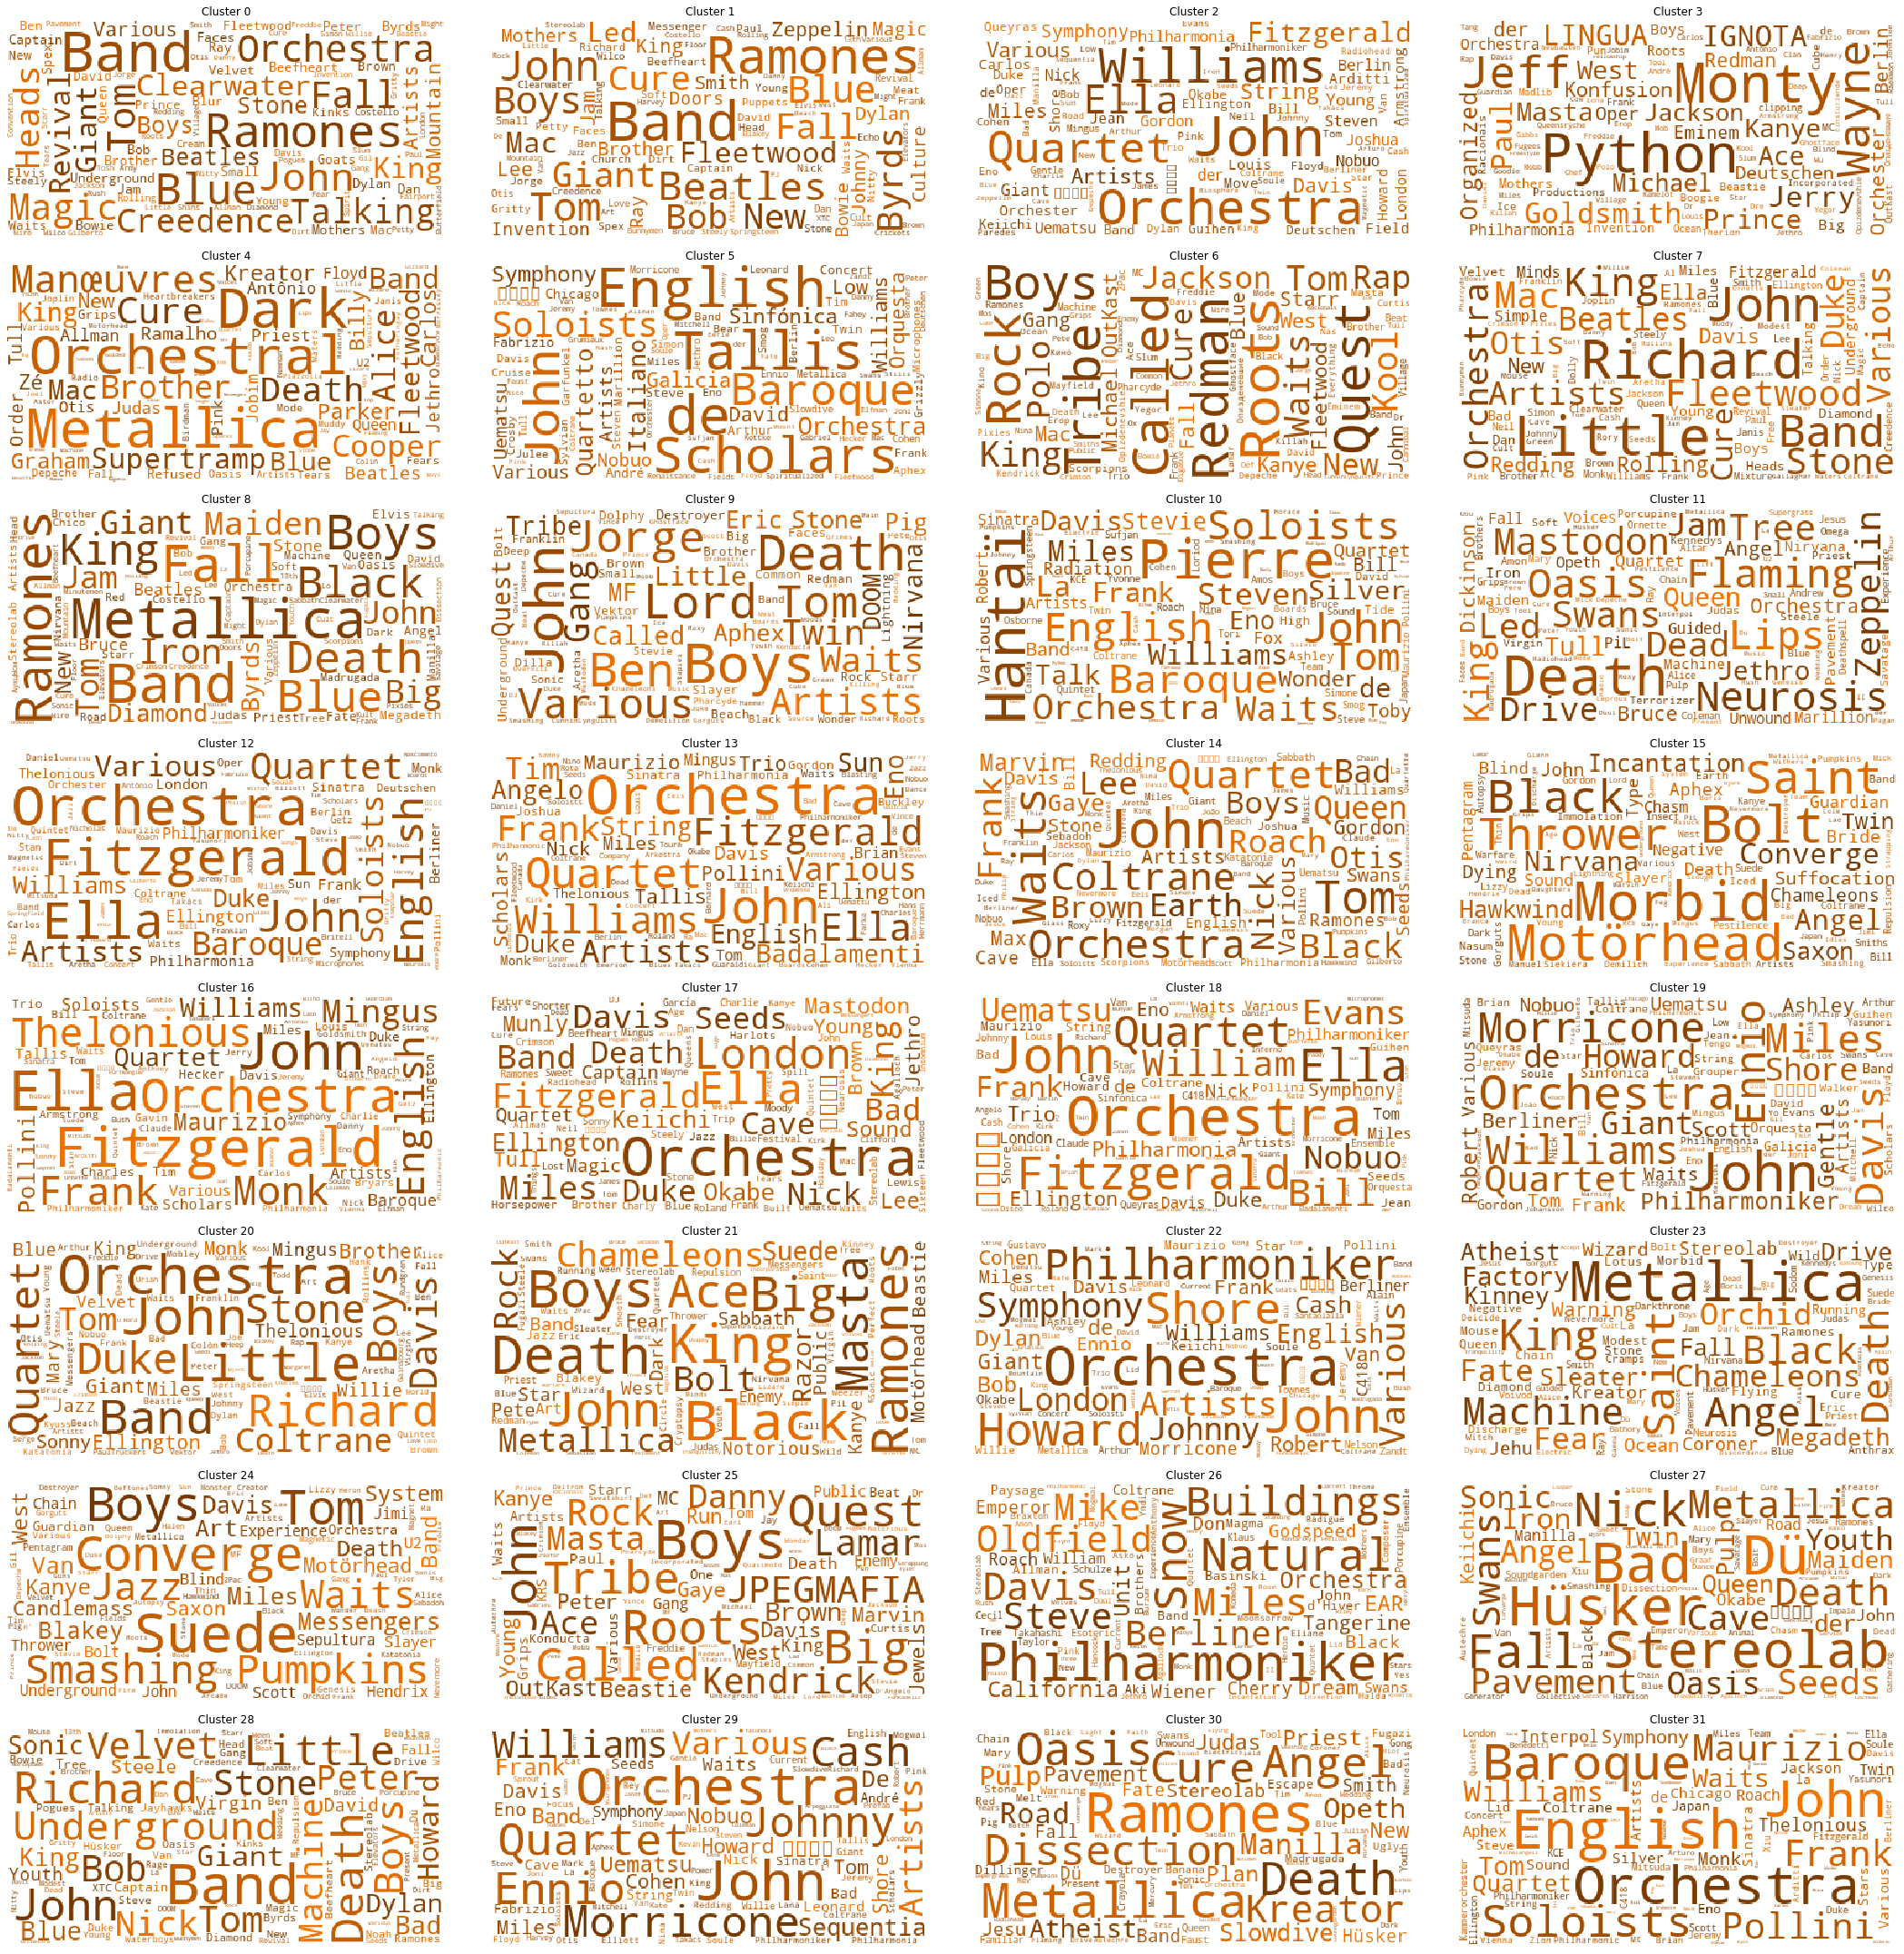

In [28]:
create_cluster_plot(4, 8, cluster_rym_data)